#  1. Introduction

# Startup Expansion Dataset — Data Analysis

This project analyzes a Startup Expansion dataset to understand the key factors that influence expansion decisions across different store locations. The data includes geographical attributes, marketing investments, revenue performance, and expansion outcomes.

## Goals

- Clean and prepare the dataset.
- Engineer new useful features (e.g., Revenue-to-Marketing Ratio, Region Performance Category).
- Explore relationships between marketing spend, revenue, geographic regions, and expansion status.
- Extract actionable insights supported by visualizations to understand what drives store expansion.

These insights can later support a predictive model for expansion probability.

#  2. Importing Libraries

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

%matplotlib inline

# Display formatting
from IPython.core.display import HTML
HTML("""
<style>
.dataframe table, .dataframe th, .dataframe td { font-size: 12px; }
div.output_scroll { overflow-x: auto; }
</style>
""")

#  3. Loading Dataset

In [2]:
startups = pd.read_excel("startup-expansion.xlsx")
startups

,Store ID,City,State,Sales Region,New Expansion,Marketing Spend,Revenue
0,1,Peoria,Arizona,Region 2,Old,2601,48610
1,2,Midland,Texas,Region 2,Old,2727,45689
2,3,Spokane,Washington,Region 2,Old,2768,49554
3,4,Denton,Texas,Region 2,Old,2759,38284
4,5,Overland Park,Kansas,Region 2,Old,2869,59887
...,...,...,...,...,...,...,...
145,146,Paterson,New Jersey,Region 1,New,2251,34603
146,147,Brownsville,Texas,Region 2,New,3675,63148
147,148,Rockford,Illinois,Region 1,New,2648,43377
148,149,College Station,Texas,Region 2,New,2994,22457


### Initial Impression
 - Check dataset info and sample rows.
 - Identify missing values or inconsistencies.
 - Generate statistical summaries using `df.describe()` to review the distribution and basic statistics of all numerical features.

In [3]:
print("Dataset shape:", startups.shape)
startups.info()
startups.sample(5)

Dataset shape: (150, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Store ID         150 non-null    int64 
 1   City             150 non-null    object
 2   State            150 non-null    object
 3   Sales Region     150 non-null    object
 4   New Expansion    150 non-null    object
 5   Marketing Spend  150 non-null    int64 
 6   Revenue          150 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 8.3+ KB


,Store ID,City,State,Sales Region,New Expansion,Marketing Spend,Revenue
53,54,Everett,Washington,Region 2,Old,3129,15562
29,30,Edison,New Jersey,Region 1,Old,3131,22972
36,37,Inglewood,California,Region 2,Old,2904,20455
49,50,Olathe,Kansas,Region 2,Old,3082,41460
48,49,San Angelo,Texas,Region 2,Old,2939,50233


In [4]:
startups[['Marketing Spend','Revenue']].describe().round(2)

,Marketing Spend,Revenue
count,150.00,150.00
mean,2893.15,39301.43
std,367.86,15465.75
min,1811.00,15562.00
25%,2662.25,21113.50
50%,2898.00,42993.00
75%,3111.50,51145.50
max,3984.00,68828.00


**General Observation:**
 - Marketing spend is relatively similar across branches, while revenue varies significantly.
 - This may indicate that other factors, such as geographic location or branch management, have a stronger impact on revenue than marketing spend alone.

In [5]:
startups.describe(include='O')

,City,State,Sales Region,New Expansion
count,150,150,150,150
unique,149,35,2,2
top,Rochester,California,Region 2,Old
freq,2,40,86,140


**Observation**
- Most cities are unique (149 out of 150), so city-level analysis may have limited value.  
- California has the highest number of branches (40 out of 150), making state a useful feature.  
- Region 2 contains the majority of branches (86 out of 150), so sales region is an important factor.  
- The target column `new_expansion` is highly imbalanced, with most branches labeled "Old" (140 out of 150), which should be considered in predictive modeling.


# 4. Data Wrangling 

In [6]:
startups.rename(columns={
    "Store ID": "store_id",
    "City": "city",
    "State": "state",
    "Sales Region": "sales_region",
    "New Expansion": "new_expansion",
    "Marketing Spend": "marketing_spend",
    "Revenue": "revenue"
}, inplace=True)

**Note on Column Renaming**

We renamed the dataset columns to **follow a consistent and professional format** (lowercase with underscores).  
This makes the dataset easier to work with in Python, especially for:

- Writing clean and readable code
- Avoiding errors caused by spaces or special characters in column names

In [7]:
startups.isna().sum()

store_id           0
city               0
state              0
sales_region       0
new_expansion      0
marketing_spend    0
revenue            0
dtype: int64

In [8]:
startups.duplicated().sum()

np.int64(0)

**Observation**
- The dataset has **no missing values**.  
- There are **no duplicate records**, ensuring data integrity for analysis.

#  5. Feature Engineering

In [9]:
startups['profits'] = startups['revenue'] - startups['marketing_spend']

**Feature:**
- The **profits** feature represents the net earnings of each store after subtracting marketing spend from revenue.  
- This helps identify which stores generate strong financial performance beyond just high revenue.

In [10]:
startups['roms_percent'] = round((startups['profits'] / startups['marketing_spend']) * 100,2)

**Feature:**
- The **roms_percent** feature represents the Return On Marketing Spend as a percentage.  
- It shows how much profit a store generates for every dollar spent on marketing, expressed in percent.  
Higher values indicate more efficient marketing performance.

In [11]:
startups['roms_ratio'] = startups['roms_percent'] / 100

**Feature:**
- The **roms_ratio** feature is the decimal form of ROMS%.  
- It converts the percentage into a ratio by dividing by 100, making it more suitable for modeling and mathematical analysis.  
For example, 120% becomes 1.20, and 50% becomes 0.50.

In [12]:
bins = [0, 30000, 50000, startups['revenue'].max()]
labels = ['Low', 'Medium', 'High']
startups['region_perf'] = pd.cut(startups['revenue'], bins=bins, labels=labels)

**Feature:**
- Classifies branches into **Low, Medium, High** performance based on revenue.
- Makes it easier to **compare regions** and understand which areas perform better.

In [13]:
mean_marketing = startups['marketing_spend'].mean()
startups['high_marketing_flag'] = startups['marketing_spend'] > mean_marketing

**Feature:**
- Marks branches that **spend above the average on marketing**.
- Useful to analyze whether **higher spending leads to higher revenue or expansion**.

In [14]:
startups['new_expansion_flag'] = startups['new_expansion'].map({'Old':0, 'New':1})

**Feature:**
- Converts the categorical target `new_expansion` into **numeric 0/1**.
- Facilitates **analysis and predictive modeling**.

#  6. Exploratory Data Analysis (EDA)

In [15]:
startups.sample(10)

,store_id,city,state,sales_region,new_expansion,marketing_spend,revenue,profits,roms_percent,roms_ratio,region_perf,high_marketing_flag,new_expansion_flag
93,94,Aurora,Illinois,Region 1,Old,2685,50650,47965,1786.41,17.8641,High,False,0
77,78,New Haven,Connecticut,Region 1,Old,3162,45550,42388,1340.54,13.4054,Medium,True,0
73,74,Murfreesboro,Tennessee,Region 2,Old,2777,40545,37768,1360.03,13.6003,Medium,False,0
115,116,Woodbridge,New Jersey,Region 1,Old,3319,19811,16492,496.90,4.9690,Low,True,0
95,96,Dayton,Ohio,Region 1,Old,2805,42026,39221,1398.25,13.9825,Medium,False,0
130,131,Savannah,Georgia,Region 1,Old,2028,36029,34001,1676.58,16.7658,Medium,False,0
53,54,Everett,Washington,Region 2,Old,3129,15562,12433,397.35,3.9735,Low,True,0
66,67,Oceanside,California,Region 2,Old,3084,55684,52600,1705.58,17.0558,High,True,0
132,133,Des Moines,Iowa,Region 1,Old,2995,57432,54437,1817.60,18.1760,High,True,0
4,5,Overland Park,Kansas,Region 2,Old,2869,59887,57018,1987.38,19.8738,High,False,0


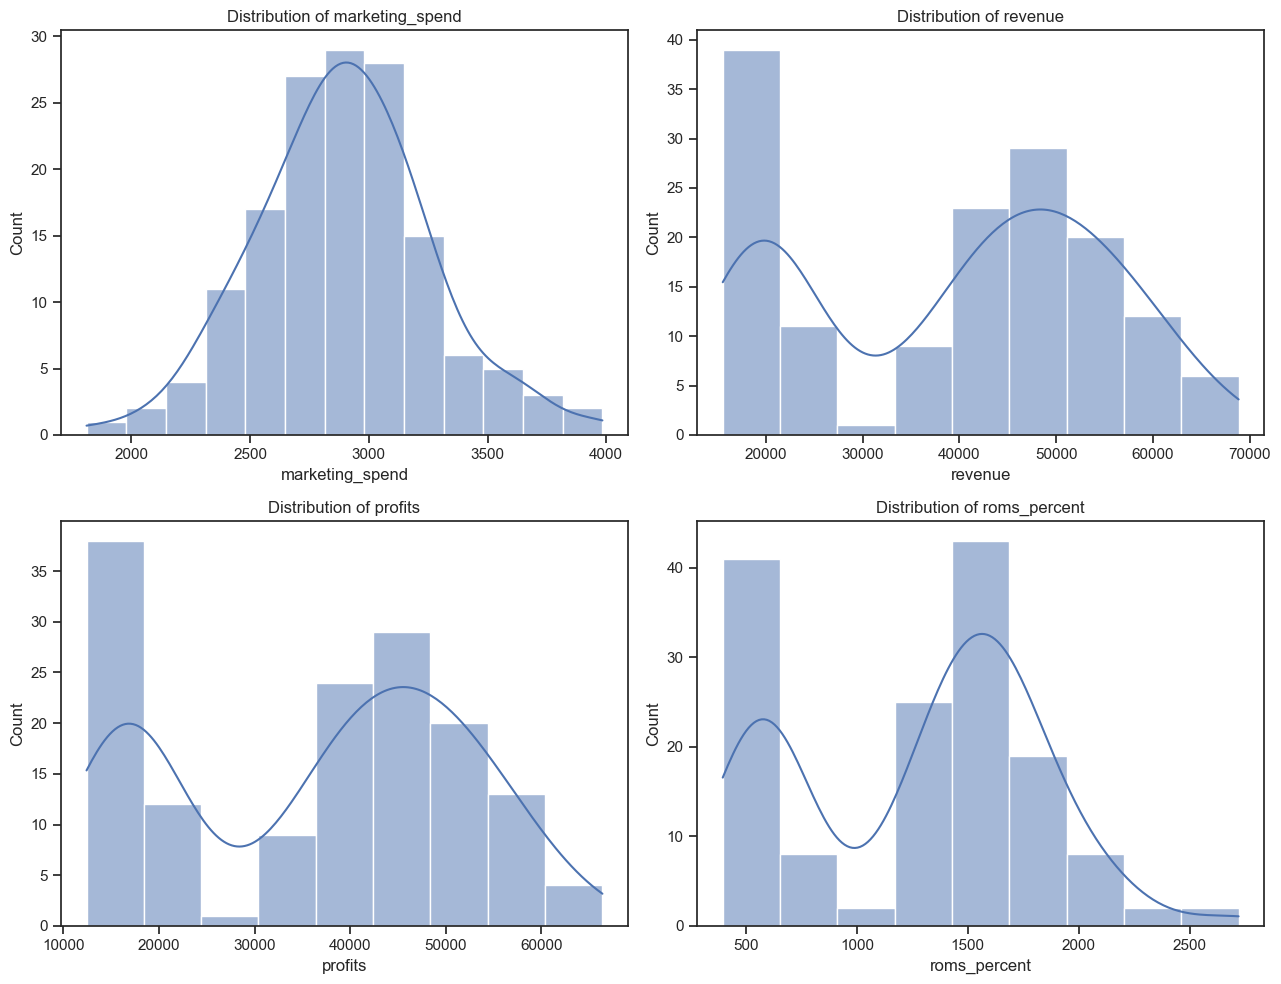

In [16]:
numeric_cols = ['marketing_spend','revenue','profits','roms_percent']
fig, axes = plt.subplots(2,2, figsize=(13,10))

for ax, col in zip(axes.flatten(), numeric_cols):
    sns.histplot(startups[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


**Insight:**

- Revenue has a skewed distribution, with a few branches generating very high revenue.  
- Profits closely follow the revenue pattern.  
- ROMS% shows high variability, indicating that some branches spend a lot on marketing without generating a proportional return.


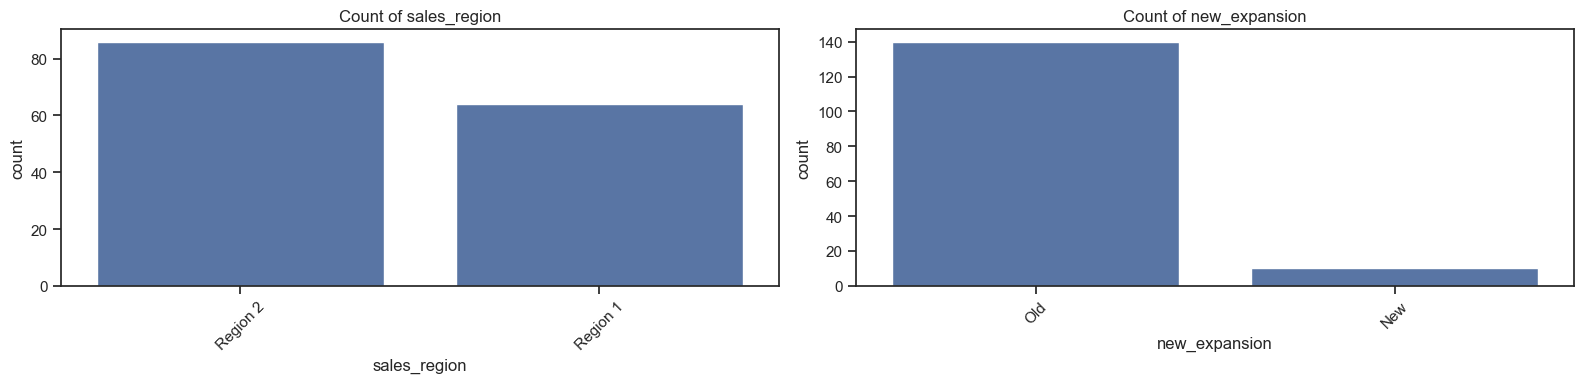

In [17]:
cat_cols = ['sales_region','new_expansion']
fig, axes = plt.subplots(1,2, figsize=(16,4))

for ax, col in zip(axes, cat_cols):
    sns.countplot(data=startups, x=col, ax=ax)
    ax.set_title(f"Count of {col}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Insight:**

- The number of branches labeled as "New" is very low (around 10), showing that expansion is limited.  
- Region 2 contains more branches than Region 1, making it the dominant sales region in the dataset.

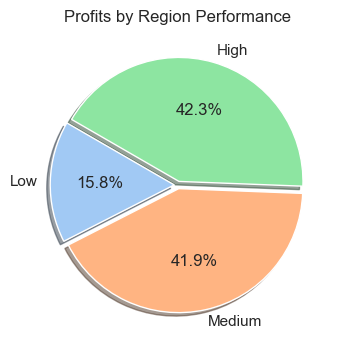

In [18]:
profits_by_region = startups.groupby('region_perf', observed=True)['profits'].sum()

plt.figure(figsize=(4,6))
plt.pie(
    profits_by_region,
    labels=profits_by_region.index,
    autopct='%1.1f%%',
    startangle=150,
    colors=sns.color_palette('pastel')[0:len(profits_by_region)],
    explode=[0.03]*len(profits_by_region),
    shadow=True
)
plt.title('Profits by Region Performance', fontsize=12)
plt.show()

**Insight:**  
- High and Medium revenue startups account for over 84% of total profits, making them the most impactful on overall profitability.  
- Low revenue startups represent only 15.8% and need improved growth strategies to increase their contribution.

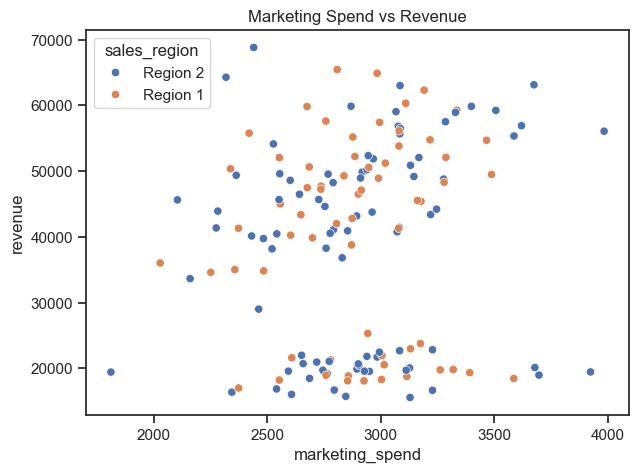

In [19]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=startups, x='marketing_spend', y='revenue', hue='sales_region')
plt.title("Marketing Spend vs Revenue")
plt.show()


**Insight:**

- The correlation between marketing spend and revenue is weak.  
- Some branches with low marketing spend still achieve excellent revenue, indicating that **location and sales region** are more important factors.

In [20]:
region_stats = startups.groupby('sales_region').agg({
    'revenue':'mean',
    'profits':'mean',
    'roms_percent':'mean',
    'new_expansion_flag':'mean'
}).round(2)

region_stats


,revenue,profits,roms_percent,new_expansion_flag
sales_region,,,,
Region 1,40567.20,37678.20,1320.43,0.05
Region 2,38359.47,35463.23,1240.11,0.08


**Insight:**
- Region 2 has the highest number of stores, but it is not necessarily the most profitable.
- Some regions achieve better ROMS even with lower marketing spending, suggesting differences in regional performance efficiency.

#  7. Export Final Clean Dataset

In [21]:
#startups.to_csv("startup-expansion-modified.csv", index=False)

#  8. Summary of Key Insights
## Summary of Insights
- The most important factor influencing expansion decisions is revenue, followed by profits.  
- Marketing spend alone is not a strong indicator of expansion or high revenue.  
- Marketing efficiency (ROMS) does not strongly explain expansion.  
- Branch distribution is uneven across regions, which may introduce bias.  
- The dataset is well-suited for developing a predictive classification model.
